In [1237]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [1343]:
df = pd.read_csv('default_data_all_variables.csv')
target = pd.read_csv('targets.csv')

In [1335]:
target = target[['home_win_odds','draw_odds','away_win_odds']]

In [1337]:
df = df.loc[:, ~df.columns.str.contains('HomeTeam|AwayTeam')]

In [1339]:
df

,matchday,total_points,total_points_home_team,total_points_away_team,5_form,5_form_home_team,5_form_away_team,10_form,10_form_home_team,10_form_away_team,total_goals,total_goals_home_team,total_goals_away_team,total_goals_against,total_goals_against_home_team,total_goals_against_away_team,total_goals_per_game,total_goals_per_game_home_team,total_goals_per_game_away_team,total_goals_against_per_game,total_goals_against_per_game_home_team,total_goals_against_per_game_away_team,5_form_goals_scored,5_form_goals_scored_home_team,5_form_goals_scored_away_team,5_form_goals_against,5_form_goals_against_home_team,5_form_goals_against_away_team,10_form_goals_scored,10_form_goals_scored_home_team,10_form_goals_scored_away_team,10_form_goals_against,10_form_goals_against_home_team,10_form_goals_against_away_team,total_shots_per_game,total_shots_per_game_home_team,total_shots_per_game_away_team,total_shots_against_per_game,total_shots_against_per_game_home_team,total_shots_against_per_game_away_team,total_shots_on_target_per_game,total_shots_on_target_per_game_home_team,total_shots_on_target_per_game_away_team,total_shots_on_target_against_per_game,total_shots_on_target_against_per_game_home_team,total_shots_on_target_against_per_game_away_team,5_form_shots,5_form_shots_home_team,5_form_shots_away_team,5_form_shots_against,5_form_shots_against_home_team,5_form_shots_against_away_team,10_form_shots,10_form_shots_home_team,10_form_shots_away_team,10_form_shots_against,10_form_shots_against_home_team,10_form_shots_against_away_team,5_form_shots_on_target,5_form_shots_on_target_home_team,5_form_shots_on_target_away_team,5_form_shots_on_target_against,5_form_shots_on_target_against_home_team,5_form_shots_on_target_against_away_team,10_form_shots_on_target,10_form_shots_on_target_home_team,10_form_shots_on_target_away_team,10_form_shots_on_target_against,10_form_shots_on_target_against_home_team,10_form_shots_on_target_against_away_team,total_yellow_cards_per_game,total_yellow_cards_per_game_home_team,total_yellow_cards_per_game_away_team,total_yellow_cards_against_per_game,total_yellow_cards_against_per_game_home_team,total_yellow_cards_against_per_game_away_team,total_red_cards_per_game,total_red_cards_per_game_home_team,total_red_cards_per_game_away_team,total_red_cards_against_per_game,total_red_cards_against_per_game_home_team,total_red_cards_against_per_game_away_team,total_xg_per_game,total_xg_per_game_home_team,total_xg_per_game_away_team,total_xg_against_per_game,total_xg_against_per_game_home_team,total_xg_against_per_game_away_team,5_form_xg,5_form_xg_home_team,5_form_xg_away_team,5_form_xg_against,5_form_xg_against_home_team,5_form_xg_against_away_team,10_form_xg,10_form_xg_home_team,10_form_xg_away_team,10_form_xg_against,10_form_xg_against_home_team,10_form_xg_against_away_team,total_points_away,total_points_home,5_form_away,10_form_away,5_form_home,10_form_home,total_goals_away,total_goals_against_away,total_goals_per_game_away,total_goals_against_per_game_away,total_goals_home,total_goals_against_home,total_goals_per_game_home,total_goals_against_per_game_home,5_form_goals_scored_away,10_form_goals_scored_away,5_form_goals_against_away,10_form_goals_against_away,5_form_goals_scored_home,10_form_goals_scored_home,5_form_goals_against_home,10_form_goals_against_home,total_shots_per_game_home,total_shots_against_per_game_home,total_shots_per_game_away,total_shots_against_per_game_away,total_shots_on_target_per_game_home,total_shots_on_target_against_per_game_home,total_shots_on_target_per_game_away,total_shots_on_target_against_per_game_away,5_form_shots_away,10_form_shots_away,5_form_shots_against_away,10_form_shots_against_away,5_form_shots_home,10_form_shots_home,5_form_shots_against_home,10_form_shots_against_home,5_form_shots_on_target_away,10_form_shots_on_target_away,5_form_shots_on_target_against_away,10_form_shots_on_target_against_away,5_form_shots_on_target_home,10_form_shots_on_target_home,5_form_shots_on_target_against_

In [1341]:
X_train = df[:-1000]
y_train = target[:-1000]
X_val = df[-1000:-500]
y_val = target[-1000:-500]
X_test = df[-500:]
y_test = target[-500:]


In [1347]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.0005)
model = Sequential()

# Input layer
model.add(Dense(256, activation='relu', input_shape=(179,)))  # 278 is the number of input features
model.add(Dropout(0.1))
# Hidden layers
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))  # Optional, to prevent overfitting
# model.add(Dense(138, activation='relu'))
# model.add(Dropout(0.1))  # Optional, to prevent overfitting
model.add(Dense(48, activation='relu'))

# Output layer (with softmax to ensure sum-to-1 constraint)
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
class_weights = {'home_win_odds': 1.0, 'draw_odds': 1, 'away_win_odds': 1.0}
# Train the model
history = model.fit(X_train, y_train, epochs=600, batch_size=1000, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[early_stopping])
# , callbacks=[early_stopping]
# Evaluate the model
results = model.evaluate(X_test, y_test)

Epoch 1/600


C:\Users\ciesl\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1148 - mae: 0.0903 - val_loss: 0.0902 - val_mae: 0.0472
Epoch 2/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0893 - mae: 0.0599 - val_loss: 0.0736 - val_mae: 0.0381
Epoch 3/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0728 - mae: 0.0515 - val_loss: 0.0602 - val_mae: 0.0370
Epoch 4/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0596 - mae: 0.0486 - val_loss: 0.0490 - val_mae: 0.0353
Epoch 5/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0487 - mae: 0.0463 - val_loss: 0.0398 - val_mae: 0.0346
Epoch 6/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0397 - mae: 0.0445 - val_loss: 0.0322 - val_mae: 0.0329
Epoch 7/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0324 - mae: 0.0433 - val_loss: 0.0261 - val_mae: 0.0333
Epoch 8/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266 - mae: 0.0428 - val_loss: 0.0211 - val_mae: 0.0327
Epoch 9/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0216 - mae: 0.

In [1348]:
results

[0.0030828844755887985, 0.038178700953722]

In [1349]:
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [1350]:
y_pred

array([[0.4766728 , 0.2679363 , 0.25539094],
       [0.6146426 , 0.22620454, 0.15915284],
       [0.77184063, 0.14790812, 0.08025122],
       ...,
       [0.4652387 , 0.26725337, 0.26750794],
       [0.4262666 , 0.29140925, 0.2823242 ],
       [0.3351224 , 0.26397914, 0.40089843]], dtype=float32)

In [1391]:
trg

,FTHG,FTAG,home_win_odds,draw_odds,away_win_odds
0,1,1,0.458753,0.266787,0.274460
1,1,1,0.628708,0.196715,0.174577
2,5,1,0.775290,0.136685,0.088025
3,2,1,0.481468,0.250448,0.268085
4,1,0,0.407562,0.271064,0.321374
...,...,...,...,...,...
495,3,2,0.392395,0.292396,0.315209
496,2,0,0.486209,0.284551,0.229241
497,4,0,0.398873,0.273154,0.327973
498,1,0,0.533203,0.245773,0.221023


In [1367]:
pred_df['home_win_odds_ratio'] = pred_df['home_win_odds']/trg['home_win_odds']

,home_win_odds,draw_odds,away_win_odds,FTHG,FTAG,probability converted
0,0.476673,0.267936,0.255391,1,1,0.267936
1,0.614643,0.226205,0.159153,1,1,0.226205
2,0.771841,0.147908,0.080251,5,1,0.771841
3,0.559706,0.247523,0.192771,2,1,0.559706
4,0.422472,0.285032,0.292496,1,0,0.422472
...,...,...,...,...,...,...
495,0.403848,0.287591,0.308561,3,2,0.403848
496,0.542880,0.258512,0.198608,2,0,0.542880
497,0.465239,0.267253,0.267508,4,0,0.465239
498,0.426267,0.291409,0.282324,1,0,0.426267


In [1413]:
columns_to_check = ['home_win_odds',	'draw_odds',	'away_win_odds']

# Function to calculate the relative difference
def relative_difference(series1, series2):
    return abs(series1 - series2)

# Check where the relative difference is greater than 10%
mask = pd.DataFrame(False, index=pred_df.index, columns=pred_df.columns)
for col in columns_to_check:
    mask[col] = relative_difference(pred_df[col], trg[col]) > 0.15

# Filter rows where any of the conditions is True
filtered_pred_df = pred_df[mask.any(axis=1)]


In [1415]:
filtered_pred_df

,home_win_odds,draw_odds,away_win_odds,FTHG,FTAG,probability converted
41,0.321963,0.281710,0.396328,1,2,0.396328
59,0.502192,0.272400,0.225407,0,2,0.225407
77,0.322479,0.274470,0.403051,1,3,0.403051
79,0.274882,0.245881,0.479236,3,1,0.274882
98,0.189413,0.228190,0.582397,1,5,0.582397
149,0.248100,0.252589,0.499311,3,0,0.248100
166,0.348318,0.267425,0.384257,0,6,0.384257
212,0.145241,0.198276,0.656483,4,2,0.145241
240,0.484996,0.271309,0.243696,0,1,0.243696
256,0.484996,0.271309,0.243696,0,1,0.243696


In [1417]:
trg.iloc[filtered_pred_df.index]

,FTHG,FTAG,home_win_odds,draw_odds,away_win_odds
41,1,2,0.216238,0.230177,0.553585
59,0,2,0.349516,0.289023,0.361461
77,1,3,0.203443,0.225212,0.571345
79,3,1,0.448718,0.239767,0.311515
98,1,5,0.301850,0.267651,0.430499
149,3,0,0.431161,0.251795,0.317044
166,0,6,0.210567,0.208880,0.580552
212,4,2,0.317054,0.215462,0.467485
240,0,1,0.323514,0.270363,0.406123
256,0,1,0.323514,0.270363,0.406123


In [1352]:
pred_df = pd.DataFrame(y_pred, columns = ['home_win_odds', 'draw_odds', 'away_win_odds'])
pred_df[['FTHG', 'FTAG']] = trg[['FTHG', 'FTAG']]
pred_df['probability converted'] = pred_df.apply(choose_value, axis=1)
pred_df['probability converted'].sum()

198.4432923644781

In [1381]:
trg.reset_index(inplace = True, drop = True)

In [1361]:
trg = target[-500:]

In [1263]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators = 200, eta = 0.1, max_depth = 30, min_child_weight = 3, booster = 'dart', tree_method = 'hist')
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [1264]:
predictions = model.predict(X_test)
softmax_predictions = softmax(predictions.reshape(-1, 3))
predictions_sum = predictions.sum(axis =1).reshape(-1, 1)
predictions/=predictions_sum
predictions

array([[0.57301056, 0.245104  , 0.18188539],
       [0.35421973, 0.28143325, 0.36434704],
       [0.45823026, 0.27592543, 0.26584432],
       [0.4978041 , 0.27032238, 0.2318735 ],
       [0.55717164, 0.26838166, 0.17444667],
       [0.34229174, 0.30927876, 0.34842947],
       [0.5561351 , 0.25235772, 0.19150713],
       [0.38411164, 0.29084826, 0.32504004],
       [0.43436742, 0.28991044, 0.27572218],
       [0.2136173 , 0.21554995, 0.5708328 ],
       [0.2136173 , 0.21554995, 0.5708328 ],
       [0.5311479 , 0.23622897, 0.2326231 ],
       [0.39783096, 0.27179316, 0.33037582],
       [0.20911214, 0.25181967, 0.5390682 ],
       [0.53061795, 0.25975704, 0.209625  ],
       [0.5777394 , 0.23487721, 0.18738337],
       [0.4384573 , 0.3064104 , 0.25513226],
       [0.50101507, 0.24844815, 0.25053677],
       [0.48411873, 0.28898928, 0.22689201],
       [0.39491513, 0.28616428, 0.31892055],
       [0.33468089, 0.29834077, 0.36697835],
       [0.46270517, 0.2971812 , 0.24011362],
       [0.

In [1265]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predictions)

0.06638638423470038

In [1266]:
pred_df = pd.DataFrame(predictions, columns = ['home_win_odds', 'draw_odds', 'away_win_odds'])
pred_df[['FTHG', 'FTAG']] = trg[['FTHG', 'FTAG']]
pred_df['probability converted'] = pred_df.apply(choose_value, axis=1)
pred_df['probability converted'].sum()

62.13303878158331

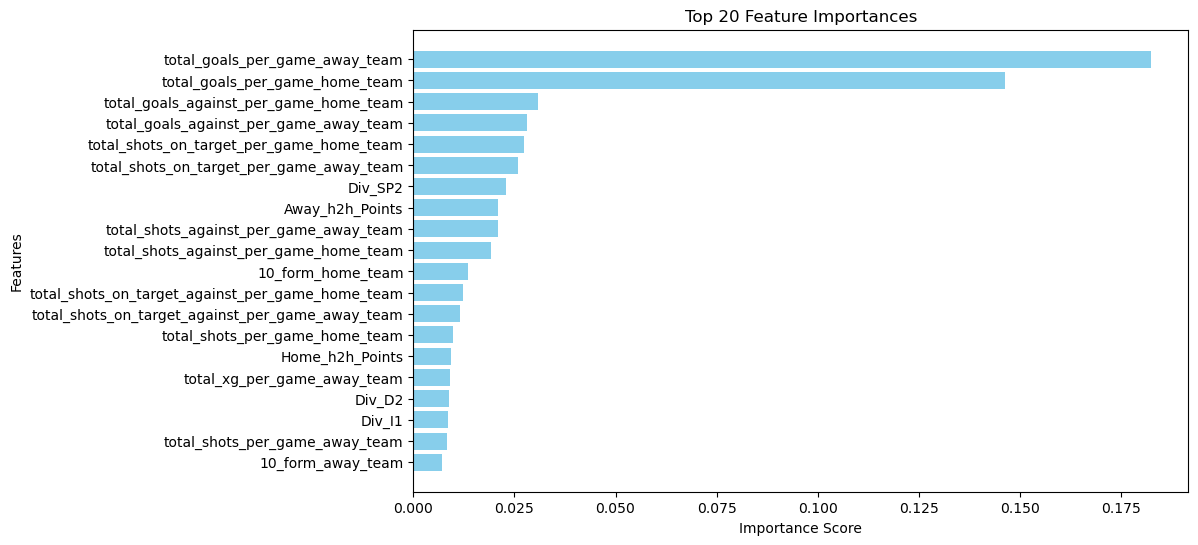

In [1267]:
import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier manipulation
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and get the top 20 features
top_20_features = feature_importances_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [1268]:
target[-200:]

,FTHG,FTAG,home_win_odds,draw_odds,away_win_odds
18847,3,2,0.689206,0.190272,0.120522
18848,1,0,0.359270,0.275322,0.365408
18849,0,2,0.467900,0.268077,0.264023
18850,3,0,0.650123,0.202544,0.147334
18851,2,2,0.582892,0.224549,0.192559
...,...,...,...,...,...
19042,3,2,0.392395,0.292396,0.315209
19043,2,0,0.486209,0.284551,0.229241
19044,4,0,0.398873,0.273154,0.327973
19045,1,0,0.533203,0.245773,0.221023


In [1269]:
trg = target[-200:]

In [1319]:
def choose_value(row):
    if row['FTHG'] > row['FTAG']:
        return row['home_win_odds']
    elif row['FTHG'] == row['FTAG']:
        return row['draw_odds']
    else:
        return row['away_win_odds']

# Apply the function to each row
trg['probability converted'] = trg.apply(choose_value, axis=1)

C:\Users\ciesl\AppData\Local\Temp\ipykernel_13620\2918088030.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trg['probability converted'] = trg.apply(choose_value, axis=1)


In [1321]:
trg['probability converted'].sum()

205.43654334046846